In [1]:
import IPython.display as ipd
import librosa
import librosa.display
from scipy.io import wavfile
import soundfile as sf
import os
from os.path import basename
import cv2
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import IPython.display as ipd
import gc
%matplotlib inline

import pickle
import tempfile
import time
import math
import keras
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation

from utils import *

seed = 0
np.random.seed(seed)
import random
random.seed(seed)

Using TensorFlow backend.
/home/arsh/anaconda3/envs/deepLearn/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def readData(data_folder_path, iterations = 50, audio_length = 45, n_mels = 128, val_split = 0.2):
    """
    Return consolidated and preprocessed wav file melspectograms and labels 
    imported from the provided locations 
    
    Arguments:
    data_folder_path  -- Path of folder containing training audio folders
    audio_length      -- Length of output audio (milliseconds)
    """
    
    # Get list of speakers for train-val split
    speakers = []
    for file_ in glob.glob(data_folder_path+'/*/*.wav'):
        if file_[file_[:file_.rfind('/')].rfind('/')+1:file_.rfind('/')]=='_background_noise_':
            continue            
        speakers.append(file_[file_.rfind('/')+1:file_.find('_')])
    
    # Split into training and validation
    train_speakers, val_speakers = train_test_split(list(set(speakers)), test_size=val_split, random_state=42)
    train_size = len([i for i in speakers if i in train_speakers])
    val_size = len([i for i in speakers if i in val_speakers])
    # Add more space for 'silence' labels
    train_size+=1950
    train_size*=10
    val_size+=450
    
    label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']
    # Load background noise files to avoid repeated loading
    bg_files = ['pink_noise.wav', 'dude_miaowing.wav', 'exercise_bike.wav',
                    'doing_the_dishes.wav', 'white_noise.wav', 'running_tap.wav']
    bg_wavs = {file_ : sf.read(data_folder_path+'/_background_noise_/'+file_)[0] for file_ in bg_files}
    
    for iter_ in range(iterations):
        print('Iteration =', iter_+1)
        # Initialize arrays for storing data
        train_features = np.zeros((train_size, audio_length, n_mels, 2), np.float32)
        train_labels = np.zeros((train_size, len(label_list)), np.int64)
        if iter_ == 0:
            val_features = np.zeros((val_size, audio_length, n_mels, 2), np.float32)
            val_labels = np.zeros((val_size, len(label_list)), np.int64)

        # For shuffling
        p = np.random.permutation(train_size)

        # Iterate over audio files to extract features and labels
        tr_num, val_num, print_num = 0, 0, 0
        length = []
        for file_ in glob.glob(data_folder_path+'/*/*.wav'):
            label = file_[file_[:file_.rfind('/')].rfind('/')+1:file_.rfind('/')]
            if label=='_background_noise_':
                continue
            if label not in label_list[:-2]:
                unknown_label = label
                label = 'unknown'
                if np.random.choice([True, False], p=[15/16, 1/16]):
                    continue

            speaker = file_[file_.rfind('/')+1:file_.find('_')]
            if (speaker in val_speakers and label != 'unknown') or (label == 'unknown' and 
                                                                    speaker in val_speakers and
                                                                    unknown_label in ['house', 'dog', 'two', 'five']):
                if iter_ == 0:
                    X, sample_rate = sf.read(file_)
                    X, _ = librosa.effects.trim(X) # Remove leading and trailing silence
                    file_feature = librosa.feature.melspectrogram(X, sample_rate, n_mels=n_mels, hop_length=370)
                    file_feature2 = librosa.feature.mfcc(X, sample_rate, n_mfcc=n_mels, hop_length=370)
                    file_feature = cv2.resize(librosa.power_to_db(file_feature, ref=np.max), (audio_length, n_mels))
                    file_feature2 = cv2.resize(file_feature2, (audio_length, n_mels))
                    file_feature = np.stack((file_feature, file_feature2), axis=2)

                    val_features[val_num] = file_feature.reshape((audio_length, n_mels, 2))
                    val_labels[val_num, label_list.index(label)] = 1.0
                    val_num+=1
            elif (speaker in train_speakers and label != 'unknown') or (
                label == 'unknown' and speaker in train_speakers and unknown_label not in ['house', 'dog', 'two', 'five']):

                # Generate samples for training with augmentation
                X, sample_rate = sf.read(file_)
                X, _ = librosa.effects.trim(X) # Remove leading and trailing silence
                stored_X, stored_sr = X, sample_rate
                for i in range(2):
                    X, sample_rate = stored_X, stored_sr
                    if label == 'unknown':
                        X = randomMix(X, sample_rate, speaker, unknown_label, u=0.6)
                    X = randomNoise(X, sample_rate, bg_wavs, u=0.94)
                    X = randomSpeed(X, sample_rate, u=0.94)

                    file_feature = librosa.feature.melspectrogram(X, sample_rate, n_mels=n_mels, hop_length=370)
                    file_feature2 = librosa.feature.mfcc(X, sample_rate, n_mfcc=n_mels, hop_length=370)
                    file_feature = cv2.resize(librosa.power_to_db(file_feature, ref=np.max), (audio_length, n_mels))
                    file_feature2 = cv2.resize(file_feature2, (audio_length, n_mels))
                    file_feature = np.stack((file_feature, file_feature2), axis=2)

                    train_features[p[tr_num]] = file_feature.reshape((audio_length, n_mels, 2))
                    train_labels[p[tr_num], label_list.index(label)] = 1.0
                    tr_num+=1

            if (tr_num+val_num)>print_num:
                print(tr_num+val_num)
                print_num+=10000

        # Add 'silence' labels
        for file_ in glob.glob(data_folder_path+'/_background_noise_/*.wav'):
            X, sample_rate = sf.read(file_)
            file_feature = librosa.power_to_db(librosa.feature.melspectrogram(X, sample_rate, n_mels=n_mels,
                                                                              hop_length=370), ref=np.max)
            file_feature2 = librosa.feature.mfcc(X, sample_rate, n_mfcc=n_mels, hop_length=370)
            file_feature = np.stack((file_feature, file_feature2), axis=2)

            random_samples = [file_feature[:,i:i+audio_length,:].reshape((audio_length, n_mels, 2))
                              for i in np.random.randint(file_feature.shape[1]-audio_length, size=(3325))]

            train_features[p[tr_num:tr_num+3250]] = random_samples[:3250]
            train_labels[p[tr_num:tr_num+3250], label_list.index('silence')] = 1.0
            val_features[val_num:val_num+75] = random_samples[3250:]
            val_labels[val_num:val_num+75, label_list.index('silence')] = 1.0
            tr_num+=3250
            val_num+=75

        # Remove blank rows
        idx_tr = np.where(np.sum(train_labels, 1)==0)[0]
        train_labels = np.delete(train_labels, idx_tr, 0)
        train_features = np.delete(train_features, idx_tr, 0)
        if iter_ == 0:
            idx_val = np.where(np.sum(val_labels, 1)==0)[0]
            val_labels = np.delete(val_labels, idx_val, 0)
            val_features = np.delete(val_features, idx_val, 0)
        
        data = {'train_X' : train_features, 'train_y' : train_labels}
        pickle.dump(data, open('./Data/training_data/train_val_'+str(iter_)+'.pickle', 'wb'))
        del train_features
        del train_labels
        gc.collect()
        
    return {'val_X' : val_features, 'val_y' : val_labels}

In [3]:
# data = readData('./Data/train/audio/', n_mels=128)

In [4]:
# data = pickle.load(open('./Data/train_val_balanced.pickle', 'rb'))

In [5]:
# pickle.dump(data, open('./Data/train_val.pickle', 'wb'))
# pickle.dump(data, open('./Data/train_val_balanced.pickle', 'wb'))
# pickle.dump(data, open('./Data/training_data/val_data.pickle', 'wb'))

#### Generator Functions

In [3]:
def train_generator():
    epoch = 0
    while True:
        train_data = pickle.load(open('./Data/training_data/train_val_'+str(epoch)+'.pickle', 'rb'))
        ids_train_split = np.arange(len(train_data['train_X']))
        for start in range(0, len(train_data['train_X']), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_data['train_X']))
            ids_train_batch = ids_train_split[start:end]
            for id_ in ids_train_batch:
                img = train_data['train_X'][id_]
                x_batch.append(img)
                y_batch.append(train_data['train_y'][id_])
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch
        if epoch<49:
            epoch+=1
        else:
            epoch = 0

In [4]:
val_data = pickle.load(open('./Data/training_data/val_data.pickle', 'rb'))
def valid_generator():
    ids_valid_split = np.arange(len(val_data['val_X']))
    while True:
        for start in range(0, len(val_data['val_X']), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(val_data['val_X']))
            ids_valid_batch = ids_valid_split[start:end]
            for id_ in ids_valid_batch:
                img = val_data['val_X'][id_]
                x_batch.append(img)
                y_batch.append(val_data['val_y'][id_])
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch

(128, 44)


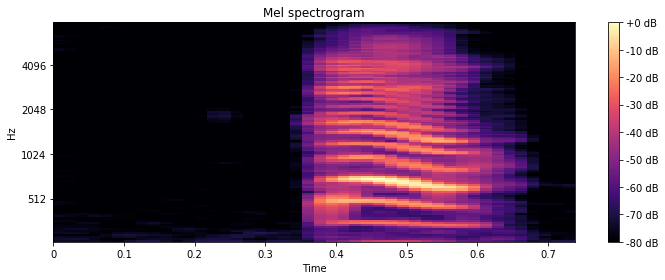

In [24]:
y, sr = sf.read('./Data/train/audio/go/0ab3b47d_nohash_1.wav')
S = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000, hop_length=370), ref=np.max)
print(S.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S, y_axis='mel', hop_length=370,
                         fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [29]:
train_data = pickle.load(open('./Data/training_data/train_val_1.pickle', 'rb'))

(128, 45)


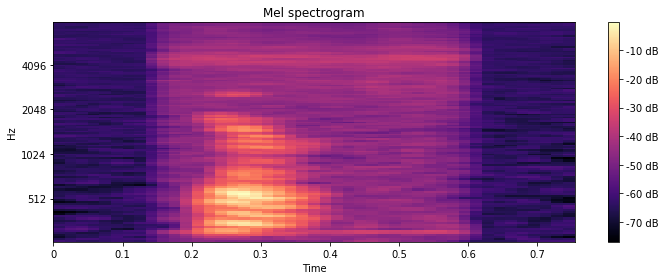

In [70]:
S = val_data['val_X'][np.where(np.argmax(val_data['val_y'], 1) == 9)[0]][5][:,:,0].reshape((128,45))
S = val_data['val_X'][np.where(np.argmax(val_data['val_y'], 1) == 9)[0]][35][:,:,0].reshape((128,45))
S = train_data['train_X'][np.where(np.argmax(train_data['train_y'], 1) == 9)[0]][33][:,:,0].reshape((128,45))
print(S.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S, y_axis='mel', hop_length=370,
                         fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

#### Train Model

In [8]:
#Create model - (Convolution layers --> Max Pooling layer) x3 --> Fully connected layer --> Dropout layer --> Readout layer
model=Sequential()

model.add(Conv2D(15, (3, 3),input_shape=(45, 128, 2), padding="same", kernel_initializer='glorot_uniform'))
model.add(Conv2D(15, (3, 3),padding="same", kernel_initializer='glorot_uniform'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(0.0))

model.add(Conv2D(45, (2, 2), padding="same", kernel_initializer='glorot_uniform'))
model.add(Conv2D(45, (2, 2), padding="same", kernel_initializer='glorot_uniform'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(0.0))

model.add(Conv2D(75, (2, 2), padding="same", kernel_initializer='glorot_uniform'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(0.0))

model.add(Flatten())
model.add(Dense(256,kernel_initializer='TruncatedNormal',activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(12,kernel_initializer='TruncatedNormal',activation='softmax'))

In [9]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-6),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-6),
             ModelCheckpoint(monitor='val_loss',
                             filepath='saved_model/keras/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='TensorBoard/keras')]

In [10]:
#Compile model
adam=Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

# Training parameters
epochs = 100
batch_size = 24

# Train the model
# model.load_weights('./CASIA_weights/best_weights.hdf5')
model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(45322) / float(batch_size)),
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks, max_queue_size=100,
                    validation_data=valid_generator(),
                    validation_steps=np.ceil(float(len(val_data['val_X'])) / float(batch_size)))

Epoch 1/100
1889/1889 [==============================] - 52s - loss: 2.2950 - acc: 0.2115 - val_loss: 2.1391 - val_acc: 0.4480
Epoch 2/100
1889/1889 [==============================] - 63s - loss: 2.0173 - acc: 0.2853 - val_loss: 2.2064 - val_acc: 0.4743
Epoch 3/100
1889/1889 [==============================] - 44s - loss: 1.9103 - acc: 0.3244 - val_loss: 2.0829 - val_acc: 0.5628
Epoch 4/100
1889/1889 [==============================] - 45s - loss: 1.8165 - acc: 0.3615 - val_loss: 1.9975 - val_acc: 0.5920
Epoch 5/100
1889/1889 [==============================] - 46s - loss: 1.7546 - acc: 0.3855 - val_loss: 1.9229 - val_acc: 0.6199
Epoch 6/100
1889/1889 [==============================] - 43s - loss: 0.6642 - acc: 0.7817 - val_loss: 1.5742 - val_acc: 0.7276
Epoch 7/100
1889/1889 [==============================] - 44s - loss: 1.6915 - acc: 0.4149 - val_loss: 1.6436 - val_acc: 0.7106
Epoch 8/100
1889/1889 [==============================] - 46s - loss: 1.6350 - acc: 0.4356 - val_loss: 1.7316 - 

In [11]:
val_predictions = model.predict_proba(val_data['val_X'])

5056/5201 [============================>.] - ETA: 0s

In [12]:
np.sum(np.argmax(val_predictions, 1) == np.argmax(val_data['val_y'], 1))/val_predictions.shape[0]

0.78561815035570082

In [38]:
idx = np.where(np.argmax(val_data['val_y'], 1)==10)[0]
preds = np.argmax(val_predictions[idx], 1)

In [41]:
preds

array([ 7,  7,  7,  3,  2,  1,  0,  7,  1,  0,  8,  5,  0, 10,  7, 10,  9,
        5,  7,  9,  7,  9,  7,  5,  4, 10,  6,  6, 10,  5,  6,  6,  5,  7,
        5,  6,  2,  7, 10,  7,  8,  8,  6, 10,  6, 10, 10, 10,  8,  6, 10,
       10, 10,  2,  7,  8,  8,  1, 10,  8,  3,  7,  3,  8,  3, 10,  8,  8,
        3,  1,  9,  8, 10, 10, 10,  3, 10, 10,  6,  9, 10, 10, 10, 10,  9,
        1, 10, 10, 10, 10, 10,  9, 10,  9, 10,  9, 10,  3, 10, 10, 10, 10,
       10, 10])

In [19]:
np.sum(val_data['val_y'], 0)

array([475, 468, 466, 448, 484, 497, 457, 444, 464, 444, 104, 900])

In [28]:
temp = np.argmax(val_predictions, 1)
unique, counts = np.unique(temp, return_counts=True)
dict(zip(unique, counts))

{0: 532,
 1: 413,
 2: 403,
 3: 447,
 4: 437,
 5: 474,
 6: 452,
 7: 445,
 8: 476,
 9: 65,
 10: 149,
 11: 908}

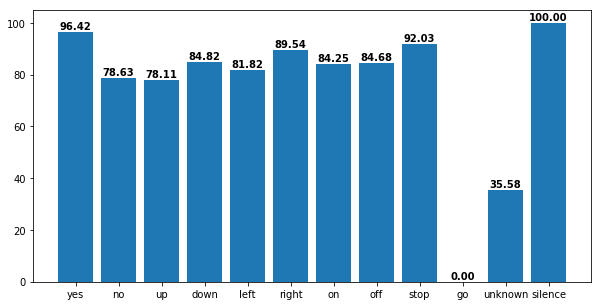

75.4895416161


In [13]:
class_acc = []
for i in range(12):
    idx = np.where(np.argmax(val_data['val_y'], 1)==i)[0]
    preds = np.argmax(val_predictions[idx], 1)
    class_acc.append((100*np.sum(np.argmax(val_data['val_y'][idx], 1) == preds))/idx.shape[0])

label_list = 'yes no up down left right on off stop go'.split()+['unknown', 'silence']
plt.figure(figsize=(10,5))
plt.bar(np.arange(12), class_acc)
plt.xticks(np.arange(12), label_list)
for i, v in enumerate(class_acc):
    plt.text(i, v+1, str('{0:.2f}'.format(v)), color='black', fontweight='bold', ha='center')
plt.show()
print(np.mean(class_acc))